# Using an SAE as a steering vector

This notebook demonstrates how to use SAE lens to identify a feature on a pretrained model, and then construct a steering vector to affect the models output to various prompts. This notebook will also make use of Neuronpedia for identifying features of interest.

The steps below include:



*   Installing relevant packages (Colab or locally)
*   Load your SAE and the model it used
*   Determining your feature of interest and its index
*   Implementing your steering vector





<a target="_blank" href="https://colab.research.google.com/github/tatsath/Interpretability/blob/main/sae_lens_based_steering.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Setting up packages and notebook

### Import and installs

In [1]:
import torch
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.5.1+cu124
CUDA Available: True
CUDA Version: 12.4


#### Environment Setup


In [2]:
try:
    # for google colab users
    import google.colab  # type: ignore
    from google.colab import output

    COLAB = True
    %pip install sae-lens transformer-lens
except:
    # for local setup
    COLAB = False
    from IPython import get_ipython  # type: ignore

    ipython = get_ipython()
    assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

# Imports for displaying vis in Colab / notebook
import webbrowser
import http.server
import socketserver
import threading

PORT = 8000

# general imports
import os
import torch
from tqdm import tqdm
import plotly.express as px

torch.set_grad_enabled(False);

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.1/920.1 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.2/189.2 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 435.0/435.0 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [3]:
def display_vis_inline(filename: str, height: int = 850):
    """
    Displays the HTML files in Colab. Uses global `PORT` variable defined in prev cell, so that each
    vis has a unique port without having to define a port within the function.
    """
    if not (COLAB):
        webbrowser.open(filename)

    else:
        global PORT

        def serve(directory):
            os.chdir(directory)

            # Create a handler for serving files
            handler = http.server.SimpleHTTPRequestHandler

            # Create a socket server with the handler
            with socketserver.TCPServer(("", PORT), handler) as httpd:
                print(f"Serving files from {directory} on port {PORT}")
                httpd.serve_forever()

        thread = threading.Thread(target=serve, args=("/content",))
        thread.start()

        output.serve_kernel_port_as_iframe(
            PORT, path=f"/{filename}", height=height, cache_in_notebook=True
        )

        PORT += 1

#### General Installs and device setup

In [4]:
# package import
from torch import Tensor
from transformer_lens import utils
from functools import partial
from jaxtyping import Int, Float

# device setup
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

Device: cuda


In [5]:
!pip install sae_lens

### Load your model and SAE

We're going to work with a pretrained GPT2-small model, and the RES-JB SAE set which is for the residual stream.

In [6]:
!pip install transformer_lens

In [7]:
!pip install sae_lens

In [8]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
#from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 6

# get model
# model = HookedTransformer.from_pretrained("gemma-2b", device=device)
model = HookedTransformer.from_pretrained("gemma-2b-it", device=device)


# get the SAE for this layer
# sae, cfg_dict, _ = SAE.from_pretrained(
#     release="gemma-2b-res-jb", sae_id=f"blocks.{layer}.hook_resid_post", device=device
# )

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = 'cuda:0'
)
# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Loaded pretrained model gemma-2b-it into HookedTransformer


cfg.json:   0%|          | 0.00/2.18k [00:00<?, ?B/s]

sae_weights.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

sparsity.safetensors:   0%|          | 0.00/65.6k [00:00<?, ?B/s]

blocks.6.hook_resid_post


## Determine your feature of interest and its index

### Find your feature

#### Explore through code by using the feature activations for a prompt

For the purpose of the tutorial, we are selecting a simple token prompt.

In this example we will look trying to find and steer a "Jedi" feature.

We run our prompt on our model and get the cache, which we then use with our sae to get our feature activations.

Now we'll look at the top feature activations and look them up on Neuronpedia to determine what they have been intepreted as.

In [9]:
# sv_prompt = " The Golden Gate Bridge"
sv_prompt = " Credit Risk and finance related"
sv_logits, cache = model.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model.to_tokens(sv_prompt)
print(tokens)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)

# print out the top activations, focus on the indices
print(torch.topk(sv_feature_acts, 3))

tensor([[    2, 14882, 22429,   578, 17048,  5678]], device='cuda:0')
torch.return_types.topk(
values=tensor([[[51.1006, 48.4480, 45.8199],
         [13.9248,  3.2408,  2.8413],
         [11.3779,  4.9560,  2.2917],
         [ 5.8111,  1.9680,  1.9184],
         [ 9.6689,  6.7363,  3.5001],
         [11.6716,  4.3286,  3.4718]]], device='cuda:0'),
indices=tensor([[[ 3390, 15881,  5347],
         [ 5419, 10035,   471],
         [10870,   471, 12704],
         [ 2595, 11912, 10054],
         [15847, 15857,  7906],
         [15570,  4633,  4123]]], device='cuda:0'))


In [10]:
# from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# get_neuronpedia_quick_list(
#     torch.topk(sv_feature_acts, 3).indices.tolist(),
#     #layer=layer,
#     #model="gemma-2b-it",
#     #dataset="res-jb",
# )

In [11]:
test_feature_idx_gpt = list(range(2)) + [471]

from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

# this function should open
neuronpedia_quick_list = get_neuronpedia_quick_list(sae, test_feature_idx_gpt)

if COLAB:
    # If you're on colab, click the link below
    print(neuronpedia_quick_list)

https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gemma-2b%22%2C%20%22layer%22%3A%20%226-res-jb%22%2C%20%22index%22%3A%20%220%22%7D%2C%20%7B%22modelId%22%3A%20%22gemma-2b%22%2C%20%22layer%22%3A%20%226-res-jb%22%2C%20%22index%22%3A%20%221%22%7D%2C%20%7B%22modelId%22%3A%20%22gemma-2b%22%2C%20%22layer%22%3A%20%226-res-jb%22%2C%20%22index%22%3A%20%22471%22%7D%5D


As we can see from our print out of tokens, the prompt is made of three tokens in total - "<endoftext>", "J", and "edi".

Our feature activation indexes at sv_feature_acts[2] - for "edi" - are of most interest to us.

Because we are using pretrained saes that have published feature maps, you can search on Neuronpedia for a feature of interest.

### Steps for Neuronpedia use

Use the interface to search for a specific concept or item and determine which layer and at what index it is.

1.   Open the [Neuronpedia](https://www.neuronpedia.org/) homepage.
2.   Using the "Models" dropdown, select your model. Here we are using GPT2-SM (GPT2-small).
3.   The next page will have a search bar, which allows you to enter your index of interest. We're interested in the "RES-JB" SAE set, make sure to select it.
4.   We found these indices in the previous step: [ 7650,   718, 22372]. Select them in the search to see the feature dashboard for each.
5.   As we'll see, some of the indices may relate to features you don't care about.

From using Neuronpedia, I have determined that my feature of interest is in layer 2, at index 7650: [here](https://www.neuronpedia.org/gpt2-small/2-res-jb/7650) is the feature.

### Note: 2nd Option - Starting with Neuronpedia

Another option here is that you can start with Neuronpedia to identify features of interest. By using your prompt in the interface you can explore which features were involved and search across all the layers. This allows you to first determine your layer and index of interest in Neuronpedia before focusing them in your code. Start [here](https://www.neuronpedia.org/search) if you want to begin with search.

## Implement your steering vector and affect the output

### Define values for your steering vector
To create our steering vector, we now need to get the decoder weights from our sparse autoencoder found at our index of interest.

Then to use our steering vector, we want a prompt for text generation, as well as a scaling factor coefficent to apply with the steering vector

We also set common sampling kwargs - temperature, top_p and freq_penalty

In [257]:
steering_vector = sae.W_dec[471]

#example_prompt = "What is the most iconic structure known to man?"
example_prompt = """Provide a sentiment for the sentence provided strictly with only one out of these five categories without much explanation - 'Very Positive', 'Very Negative', 'Neutral', 'Somewhat Positive',
       'Somewhat Negative' . - The company reported a significant drop in quarterly revenue but has successfully secured long-term financing and reduced outstanding debt."""
coeff = 150
sampling_kwargs = dict(temperature=0.0, top_p=0.0, freq_penalty=1.0)

### Set up hook functions

Finally, we need to create a hook that allows us to apply the steering vector when our model runs generate() on our defined prompt. We have also added a boolean value 'steering_on' that allows us to easily toggle the steering vector on and off for each prompt


In [258]:
def steering_hook(resid_pre, hook):
    if resid_pre.shape[1] == 1:
        return

    position = sae_out.shape[1]
    if steering_on:
        # using our steering vector and applying the coefficient
        resid_pre[:, : position - 1, :] += coeff * steering_vector


def hooked_generate(prompt_batch, fwd_hooks=[], seed=None, **kwargs):
    if seed is not None:
        torch.manual_seed(seed)

    with model.hooks(fwd_hooks=fwd_hooks):
        tokenized = model.to_tokens(prompt_batch)
        result = model.generate(
            stop_at_eos=False,  # avoids a bug on MPS
            input=tokenized,
            max_new_tokens=50,
            do_sample=False,
            **kwargs,
        )
    return result

In [259]:
def run_generate(example_prompt):
    model.reset_hooks()
    editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
    res = hooked_generate(
        [example_prompt] * 1, editing_hooks, seed=None, **sampling_kwargs
    )


    # Print results, removing the ugly beginning of sequence token
    res_str = model.to_string(res[:, 1:])

    # Remove the prompt from the generated text, handling list case
    if isinstance(res_str, list):  # Check if res_str is a list
        res_str = [s.replace(example_prompt, "").strip() for s in res_str]
    else:
        res_str = res_str.replace(example_prompt, "").strip()
    # print(res_str)
    return res_str
    # print(("\n\n" + "-" * 80 + "\n\n").join(res_str))

### Generate text influenced by steering vector

You may want to experiment with the scaling factor coefficient value that you set and see how it affects the generated output.

In [251]:
steering_on = True
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

["<eos>The sentence is about a company's financial situation. The company reported a significant drop in quarterly revenue, which is a negative event. However, the company has successfully secured long-term financing and reduced outstanding debt, which are positive events. Therefore"]

In [218]:
import re

def extract_sentiment(text):
    """
    Extracts one of the target sentiments from a sentence.

    Args:
        text: The input sentence.

    Returns:
        The extracted sentiment phrase (string), or None if not found.
    """
    sentiments = [
        "Very Positive",
        "Very Negative",
        "Neutral",
        "Somewhat Positive",
        "Somewhat Negative",
    ]

    # Create a regex pattern to match any of the sentiments, ignoring case and quotes
    pattern = r"(?:'|\")?(" + "|".join(sentiments) + r")(?:'|\")?"

    # Find the sentiment within the text
    match = re.search(pattern, text, re.IGNORECASE)

    if match:
        # Return the matched sentiment phrase
        return match.group(1)

    return None  # Return None if no sentiment is found

In [219]:
sentence = "The sentence is somewhat positive.<eos>"
extracted_sentiment = extract_sentiment(sentence)
print(extracted_sentiment)  # Output: positive

somewhat positive


### Generate text with no steering

In [220]:
steering_on = False
run_generate(example_prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

["<eos>The sentence suggests that the company's financial situation has improved, which could be considered a positive development.<eos>The sentiment is therefore 'Somewhat Positive'.<eos><eos><eos><eos><eos>The sentence suggests that the company's financial situation has improved, which"]

## Confusion Metric

In [221]:
# prompt: get distinct columns from the Sentiment column of this df

import pandas as pd

df = pd.read_excel('https://raw.githubusercontent.com/ashater/sae/master/sentence_sentiment_gpt4o.xlsx')
distinct_sentiments = df['Sentiment'].unique()
distinct_sentiments

array(['Very Positive', 'Very Negative', 'Neutral', 'Somewhat Positive',
       'Somewhat Negative'], dtype=object)

In [222]:
df["Sentence"][0]

'The company reported record-breaking revenue growth of 40% this quarter, driven by robust sales and successful product launches.'

In [261]:
import pandas as pd
import random

# Assuming you have already loaded your DataFrame as 'df' and have the necessary functions

compared_df = pd.DataFrame(columns=['index', 'sentiment_annotated', 'sentence_not_steered', 'sentence_steered' ])
system_prompt = """Give the sentiment of the sentence strictly in one of the following 5 catgories - 1) 'Very Positive', 2) 'Very Negative', 3) 'Neutral', 4)'Somewhat Positive',
       5) 'Somewhat Negative' ."""

num_sentences_to_select = 10

for _ in range(num_sentences_to_select):
    random_index = random.choice(df.index)
    sentence = df["Sentence"][random_index]

    # Get non steered response
    question_prompt = system_prompt + sentence
    #print (question_prompt)
    steering_on = False
    response_not_steered = run_generate(question_prompt)
    print("Sentence : " , sentence)

    print(response_not_steered)
    response_not_steered = extract_sentiment ( response_not_steered[0] )
    print("Not steered sentiment : " , response_not_steered)
    steering_on = True
    response_steered = run_generate(question_prompt)

    print(response_steered)
    response_steered = extract_sentiment( response_steered[0] )
    print("Steered sentiment : ", response_steered)


    # Append results to DataFrame
    new_row = pd.DataFrame({
        'index': [random_index],
        'sentiment_annotated': [df['Sentiment'][random_index]],
        'sentence_not_steered': [response_not_steered],
        'sentence_steered': [response_steered],
    })
    compared_df = pd.concat([compared_df, new_row], ignore_index=True)
    compared_df['sentence_not_steered'] = compared_df['sentence_not_steered'].str.replace('.', '', regex=False)
    compared_df['sentence_steered'] = compared_df['sentence_steered'].str.replace('.', '', regex=False)

# Display the DataFrame
print(compared_df)

  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  Internal power struggles have paralyzed decision-making, worsening the firm's financial crisis.
['The sentiment of the sentence is quite negative, indicating a sense of paralysis and worsening financial situation.<eos><eos>The sentiment of the sentence is very negative, indicating a sense of paralysis and worsening financial situation.<eos><eos><eos>The sentiment of the sentence is']
Not steered sentiment :  very negative


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence indicates a negative impact on the firm's financial situation.<eos>The sentence is a negative statement, expressing a negative impact on the firm's financial situation. Therefore, the answer is 2) 'Very Negative'.<eos><eos><eos>"]
Steered sentiment :  Very Negative


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  A modest increase in real estate fund commitments enhanced overall AUM growth.
["The sentiment of the sentence is 'Somewhat Positive'.<eos>The sentence suggests that the real estate fund commitments increased, which could lead to a positive impact on the overall AUM growth.<eos><eos><eos>The sentiment of the sentence is 'Somewhat Positive'."]
Not steered sentiment :  Somewhat Positive


  0%|          | 0/50 [00:00<?, ?it/s]

['The sentence is talking about the impact of a certain investment strategy on the overall asset management fund.<eos>The sentence is talking about the impact of a certain investment strategy on the overall asset management fund.\n\nThe sentence is talking about the impact of a']
Steered sentiment :  None


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  The SPE’s asset valuation methodologies remain consistent with industry norms, providing transparency and confidence to its investors.
["The sentiment of the sentence is 'Very Positive'. It expresses a high level of confidence and certainty in the SPE's asset valuation methodologies.<eos><eos>The sentiment of the sentence is 'Very Positive'. It expresses a high level of confidence and certainty"]
Not steered sentiment :  Very Positive


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence is about the SPE's asset valuation methodologies. It is a neutral statement, expressing a neutral opinion about the SPE's methodologies.<eos><eos>The sentence is neutral, expressing a neutral opinion about the SPE's methodologies.<eos><eos>"]
Steered sentiment :  neutral


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  Shareholders raised concerns about the bank’s slower-than-expected progress on diversifying its leadership team.
["The sentiment of the sentence is somewhat negative as it expresses concerns about the bank's progress in diversifying its leadership team.<eos><eos>The sentiment of the sentence is somewhat negative as it expresses concerns about the bank's progress in diversifying its"]
Not steered sentiment :  somewhat negative


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence suggests that shareholders are concerned about the bank's lack of progress in diversifying its leadership team.<eos>The sentence is somewhat negative as it expresses concerns about the bank's progress in diversifying its leadership team.<eos><eos>The sentence"]
Steered sentiment :  somewhat negative


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  A slight increase in fund redemption fees was observed to manage liquidity risks.
['The sentiment of the sentence is neutral. It is not positive or negative, and does not have a strong emotional tone.<eos><eos><eos>The sentiment of the sentence is neutral. It is not positive or negative, and does not have a strong emotional']
Not steered sentiment :  neutral


  0%|          | 0/50 [00:00<?, ?it/s]

['The sentence is talking about the impact of the fund redemption fees on liquidity risks.<eos>The sentence is somewhat negative as it talks about a slight increase in fund redemption fees, which could potentially impact liquidity risks.<eos><eos>The sentence is somewhat negative as']
Steered sentiment :  somewhat negative


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  The balanced fund’s exposure to bonds and equities remained evenly distributed.
["The sentiment of the sentence is neutral. It is stating a fact about the fund's investments, without expressing a strong opinion or making a value judgment.<eos><eos>The sentiment of the sentence is neutral. It is stating a fact about the fund"]
Not steered sentiment :  neutral


  0%|          | 0/50 [00:00<?, ?it/s]

['The sentence is neutral. It does not have a positive or negative connotation.<eos><eos>The sentence is neutral. It does not have a positive or negative connotation.<eos><eos>The sentence is neutral. It does not have a positive or negative connotation.']
Steered sentiment :  neutral


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  Asset rebalancing efforts in global macro strategies fell short of initial targets.
['The sentiment of the sentence is negative, as it expresses a sense of failure or disappointment.<eos><eos>The sentiment of the sentence is negative, as it expresses a sense of failure or disappointment.<eos><eos><eos>The sentiment of the sentence is negative,']
Not steered sentiment :  None


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence is talking about the success or failure of asset rebalancing efforts in global macro strategies.<eos>The sentence is a 'Very Negative' as it indicates that the asset rebalancing efforts failed to achieve their initial targets.<eos><eos><eos>The sentence"]
Steered sentiment :  Very Negative


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  Global macro strategies performed as expected, with no major deviations from forecasts.
["The sentiment of the sentence is 'Very Positive'. It conveys a sense of satisfaction and accomplishment, implying that the global macro strategies were successfully implemented as planned.<eos><eos><eos>The sentiment of the sentence is 'Very Positive'. It conveys a sense of"]
Not steered sentiment :  Very Positive


  0%|          | 0/50 [00:00<?, ?it/s]

['The sentence is: "Global macro strategies performed as expected, with no major deviations from forecasts."\n\nBased on the context, the sentence is neutral. It does not express a strong positive or negative sentiment, and it does not provide any specific information']
Steered sentiment :  neutral


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  The weighted average life of junior tranches shortened slightly, reducing duration risk.
["The sentiment of the sentence is 'Somewhat Negative'.<eos>The sentence suggests that the weighted average life of junior tranches was slightly reduced, which could be considered a negative factor.<eos><eos><eos>The sentiment of the sentence is 'Somewhat Negative'.<eos>The"]
Not steered sentiment :  Somewhat Negative


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence is talking about the weighted average life of junior tranches shortened slightly.\n\nThe answer is 3) 'Neutral'.\n\nThe sentence is neutral in tone, as it does not express a strong positive or negative sentiment.<eos><eos><eos><eos>"]
Steered sentiment :  Neutral


  0%|          | 0/50 [00:00<?, ?it/s]

Sentence :  Operational efficiencies in technology integration contributed to minor cost reductions.
['The sentiment of the sentence is positive, as it expresses a sense of accomplishment and efficiency in the technology integration process.<eos><eos>The sentiment of the sentence is positive, as it expresses a sense of accomplishment and efficiency in the technology integration process.<eos>']
Not steered sentiment :  None


  0%|          | 0/50 [00:00<?, ?it/s]

["The sentence is talking about the impact of technology integration on the cost of a project. It is neutral in tone and does not express a strong positive or negative sentiment.<eos><eos>The answer is 3) 'Neutral'.\n\nThe sentence is neutral"]
Steered sentiment :  neutral
  index sentiment_annotated sentence_not_steered   sentence_steered
0    82       Very Negative        very negative      Very Negative
1  2422   Somewhat Positive    Somewhat Positive               None
2  4066             Neutral        Very Positive            neutral
3  3005   Somewhat Negative    somewhat negative  somewhat negative
4  2348   Somewhat Negative              neutral  somewhat negative
5  2536             Neutral              neutral            neutral
6  2501   Somewhat Negative                 None      Very Negative
7  2563             Neutral        Very Positive            neutral
8  1980   Somewhat Positive    Somewhat Negative            Neutral
9  2409   Somewhat Positive                 No

In [262]:
# ... (Assuming compared_df is already loaded) ...

# Remove rows with 'None' values
compared_df = compared_df.dropna()

# Convert all string columns to lowercase
for col in compared_df.select_dtypes(include=['object']).columns:
    # Convert the column to string type before applying .str.lower()
    compared_df[col] = compared_df[col].astype(str).str.lower()

compared_df

<ipython-input-262-ae3a870d1db5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compared_df[col] = compared_df[col].astype(str).str.lower()
<ipython-input-262-ae3a870d1db5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compared_df[col] = compared_df[col].astype(str).str.lower()
<ipython-input-262-ae3a870d1db5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

,index,sentiment_annotated,sentence_not_steered,sentence_steered
0,82,very negative,very negative,very negative
2,4066,neutral,very positive,neutral
3,3005,somewhat negative,somewhat negative,somewhat negative
4,2348,somewhat negative,neutral,somewhat negative
5,2536,neutral,neutral,neutral
7,2563,neutral,very positive,neutral
8,1980,somewhat positive,somewhat negative,neutral


In [263]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Before Steering
accuracy_before = accuracy_score(compared_df['sentiment_annotated'], compared_df['sentence_not_steered'])
precision_before = precision_score(compared_df['sentiment_annotated'], compared_df['sentence_not_steered'], average='weighted')  # Use 'weighted' for multi-class
recall_before = recall_score(compared_df['sentiment_annotated'], compared_df['sentence_not_steered'], average='weighted')
confusion_before = confusion_matrix(compared_df['sentiment_annotated'], compared_df['sentence_not_steered'])

# After Steering
accuracy_after = accuracy_score(compared_df['sentiment_annotated'], compared_df['sentence_steered'])
precision_after = precision_score(compared_df['sentiment_annotated'], compared_df['sentence_steered'], average='weighted')
recall_after = recall_score(compared_df['sentiment_annotated'], compared_df['sentence_steered'], average='weighted')
confusion_after = confusion_matrix(compared_df['sentiment_annotated'], compared_df['sentence_steered'])

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [264]:

metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall'],
    'Before Steering': [accuracy_before, precision_before, recall_before],
    'After Steering': [accuracy_after, precision_after, recall_after]
})

In [265]:
print("Metrics:")
print(metrics_df)
print("\nConfusion Matrix (Before Steering):")
print(confusion_before)
print("\nConfusion Matrix (After Steering):")
print(confusion_after)

Metrics:
      Metric  Before Steering  After Steering
0   Accuracy         0.428571        0.857143
1  Precision         0.500000        0.750000
2     Recall         0.428571        0.857143

Confusion Matrix (Before Steering):
[[1 0 0 0 2]
 [1 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 0]]

Confusion Matrix (After Steering):
[[3 0 0 0]
 [0 2 0 0]
 [1 0 0 0]
 [0 0 0 1]]


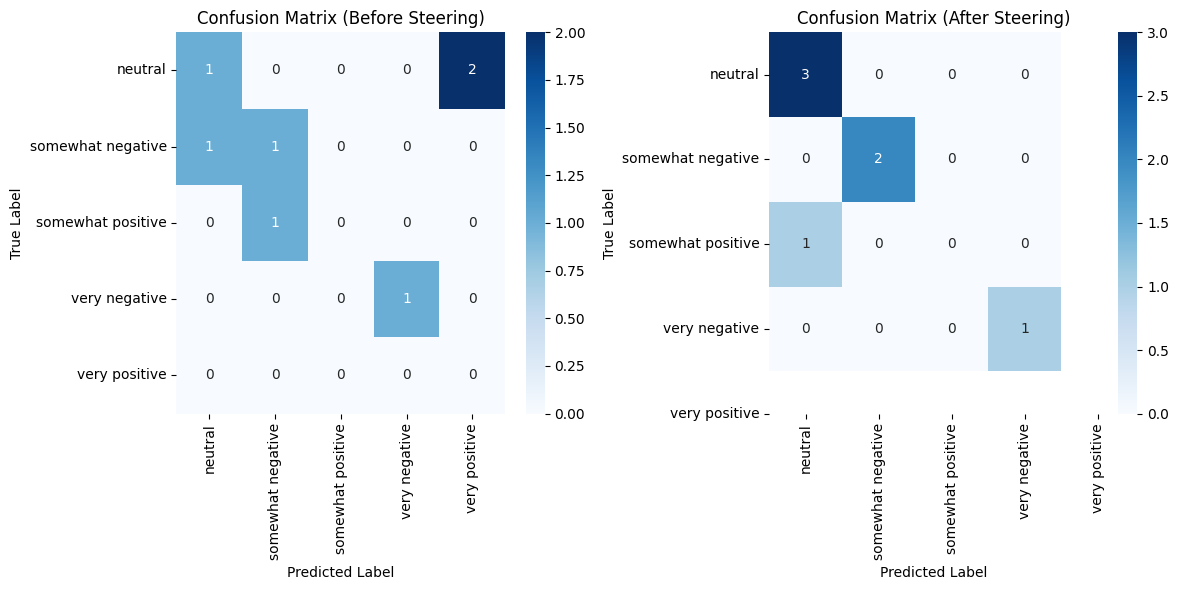

In [268]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# ... (Your existing code to calculate confusion matrices) ...


def plot_confusion_matrix(cm, labels, title, ax):
    """Plots a confusion matrix with labels on the given axis."""
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")


# Get the labels in the correct order (from compared_df)
labels = np.unique(compared_df[['sentiment_annotated', 'sentence_not_steered', 'sentence_steered']].values)

# Create a figure and axes for side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust figsize as needed

# Plot confusion matrices on the axes
plot_confusion_matrix(confusion_before, labels, "Confusion Matrix (Before Steering)", ax1)
plot_confusion_matrix(confusion_after, labels, "Confusion Matrix (After Steering)", ax2)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()